# Surface normals

Author(s): Jukka Aho

**Abstract**: Testing different strategies to calculate surface normals. These are important when calculating mortar projections.

In [1]:
using JuliaFEM

Creating element Point1: 1 node point element
Creating element Seg2: 2 node linear line element
Creating Lagrange basis for element Seg2. Number of basis functions: 2. Element dimension: 1
Calculating inverse of A
Element JuliaFEM.Seg2 created.
Creating element Seg3: 3 node quadratic line element
Creating Lagrange basis for element Seg3. Number of basis functions: 3. Element dimension: 1
Calculating inverse of A
Element JuliaFEM.Seg3 created.
Creating element Quad4: 4 node bilinear quadrangle element
Creating Lagrange basis for element Quad4. Number of basis functions: 4. Element dimension: 2
Calculating inverse of A
Element JuliaFEM.Quad4 created.
Creating element Tet10: 10 node quadratic tetrahedron
Creating Lagrange basis for element Tet10. Number of basis functions: 10. Element dimension: 3
Calculating inverse of A
Element JuliaFEM.Tet10 created.


In [2]:
using PyPlot

INFO: Precompiling module Colors...
INFO: Precompiling module LaTeXStrings...


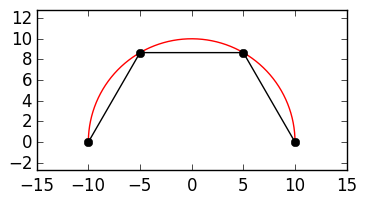

(-5.0,15.0)

In [16]:
phi = linspace(0, pi, 200)
phi2 = linspace(0, pi, 4)
figure(figsize=(4, 2))
R = 10.0
plot(R*cos(phi), R*sin(phi), "-r")
plot(R*cos(phi2), R*sin(phi2), "-ko")
#axis("off")
axis("equal")
xlim(-1.5*R, 1.5*R)
ylim(-0.5*R, 1.5*R)

Aim: to reconstruct half circle surface and calculate continous normal field. Let's create P4 hierarchial element and so on.

In [19]:
binomial(10, 5)

252

In [177]:
# Legendre polynomials

function get_legendre_polynomial_2(n)
    bin(n, k) = prod([(n + 1 - i)/i for i=1:k])
    P(xi) = sum([2^n*xi.^k*bin(n, k)*bin(1/2*(n+k-1), n) for k=0:n])
    P
end

function get_legendre_polynomial(n)
    if n == 0
        P(xi) = 0*xi + 1
    elseif n == 1
        P(xi) = xi
    else
        Pm1 = get_legendre_polynomial(n-1)
        Pm2 = get_legendre_polynomial(n-2)
        P(xi) = 1/n*( (2*n-1)*xi.*Pm1(xi) - (n-1)*Pm2(xi))
    end
    return P
end

function get_legendre_polynomial_derivative(n)
    if n == 0
        P(xi) = 0*xi
    elseif n == 1
        P(xi) = 0*xi + 1
    else
        Pm1 = get_legendre_polynomial_derivative(n-1)
        Pm2 = get_legendre_polynomial_derivative(n-2)
        P(xi) = 1/(n-1)*( (2*(n-1)+1)*xi.*Pm1(xi) - (n+1-1)*Pm2(xi))
    end
    return P
end


get_legendre_polynomial_derivative (generic function with 1 method)

In [153]:

get_legendre_polynomial(3)

P (generic function with 1 method)

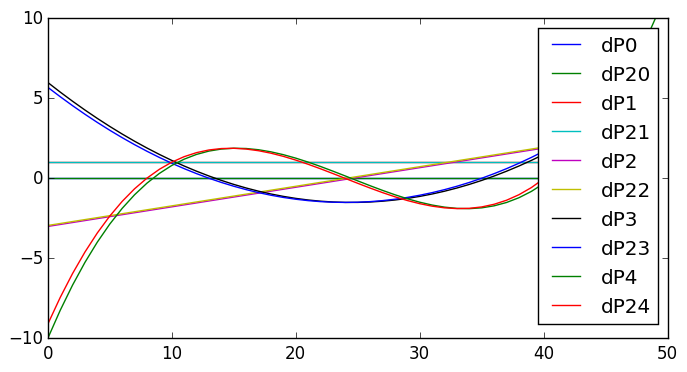

PyObject <matplotlib.legend.Legend object at 0x7f9598188a50>

In [181]:
figure(figsize=(8, 4))
xi = linspace(-1, 1)

for n=0:4
    P = get_legendre_polynomial(n)
    dP = get_legendre_polynomial_derivative(n)
    #P2 = get_legendre_polynomial_2(n)
    plot(dP(xi), label="dP$n")
    plot(diff(P(xi))./diff(xi), label="dP2$n")
    #plot(xi, P2(xi), label="P2$n")
    #println(sum(abs(P(xi)-P2(xi))))
end
#plot(1/2*(3*xi.^2 - 1), "-k")
#plot(3*xi, "-k")
#plot(1/2*(5*xi.^3 - 3*xi), "-y")
#ylim(-1.1, 1.1)
legend()

In [182]:
function get_hierarchial_basis(n)
    if n == 1
        N(xi) = 1/2*(1 - xi)
    elseif n == 2
        N(xi) = 1/2*(1 + xi)
    else
        j = n-1
        Pj = get_legendre_polynomial(j)
        Pjm2 = get_legendre_polynomial(j-2)
        N(xi) = 1/sqrt(2*(2*j-1))*(Pj(xi) - Pjm2(xi))
    end
    return N
end

function get_hierarchial_basis_derivative(n)
    if n == 1
        dN(xi) = 1/2*(0*xi - 1)
    elseif n == 2
        dN(xi) = 1/2*(0*xi + 1)
    else
        j = n-1
        Pj = get_legendre_polynomial_derivative(j)
        Pjm2 = get_legendre_polynomial_derivative(j-2)
        dN(xi) = 1/sqrt(2*(2*j-1))*(Pj(xi) - Pjm2(xi))
    end
    return dN
end

get_hierarchial_basis_derivative (generic function with 1 method)

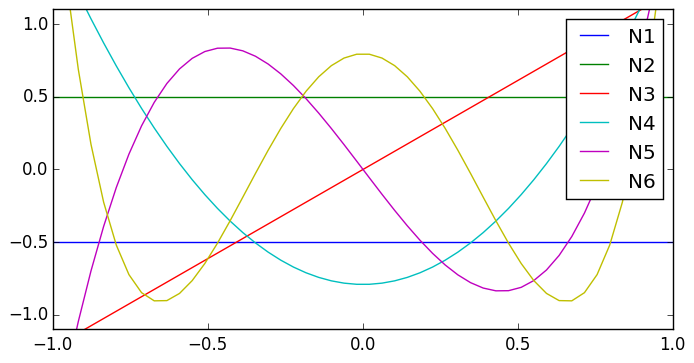

PyObject <matplotlib.legend.Legend object at 0x7f959809c090>

In [183]:
figure(figsize=(8, 4))
xi = linspace(-1, 1)

for n=1:6
    N = get_hierarchial_basis_derivative(n)
    plot(xi, N(xi), label="N$n")
end
ylim(-1.1, 1.1)
legend()

In [79]:
get_hierarchial_basis(3)([0.0])

1-element Array{Float64,1}:
 -0.612372

In [202]:
using ForwardDiff
using JuliaFEM: get_number_of_basis_functions, get_basis, get_dbasisdxi

abstract Hierarchical <: JuliaFEM.Element

type PSeg <: Hierarchical
    connectivity :: Array{Int, 1}
    fields :: Dict{Any, Any}
    degree :: Int
end

PSeg(connectivity) = PSeg(connectivity, Dict{Any,Any}(), 1)

JuliaFEM.get_number_of_basis_functions(el::Type{PSeg}) = 2
JuliaFEM.get_number_of_basis_functions(el::PSeg) = 2 + el.degree - 1
JuliaFEM.get_element_dimension(el::Type{PSeg}) = 1
function JuliaFEM.get_basis(el::PSeg, xi)
    m = get_number_of_basis_functions(el)
    out = zeros(m)
    for n=1:m
        N = get_hierarchial_basis(n)
        out[n] = N(xi)[1]
    end
    return out
end

function JuliaFEM.get_dbasisdxi(el::PSeg, xi)
    m = get_number_of_basis_functions(el)
    out = zeros(m)
    for n=1:m
        dN = get_hierarchial_basis_derivative(n)
        out[n] = dN(xi)[1]
    end
    return out
end

get_dbasisdxi (generic function with 6 methods)

In [212]:
pel = PSeg([1, 2])
pel.degree = 2
dn1 = get_dbasisdxi(pel, [-sqrt(1/3)])
dn2 = get_dbasisdxi(pel, [+sqrt(1/3)])
dn1 * dn1' + dn2 * dn2'

3x3 Array{Float64,2}:
  0.5  -0.5  0.0
 -0.5   0.5  0.0
  0.0   0.0  1.0

In [17]:
nelements = length(phi2)-1
nnodes = length(phi2)
elements = []
for i=1:nnodes
    con = [i, mod(i,nnodes)+1]
    push!(elements, JuliaFEM.Seg2
end

[1,2]
[2,3]
[3,4]
[4,1]
